In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by agency

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [3]:
table_df = df.copy()
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df

,agency,observed_boardings,model_boardings,diff,perc_diff
3,Sound Transit,"113,374.00","158,221.36","44,847.36",39.56%
4,Washington Ferries,"9,278.21","5,658.13","-3,620.08",-39.02%
1,King County Metro,"7,851.62","420,406.45","412,554.84","5,254.39%"
2,Kitsap Transit,"7,609.00","27,282.61","19,673.61",258.56%
0,Everett Transit,"4,201.00","3,183.87","-1,017.13",-24.21%


In [4]:
# fig = px.bar(plot_df.sort_values('source'), x="agency", y="count",
#              color="source", barmode="group",
#              title="transit boardings by agency")
# fig.update_layout(height=400, width=700, font=dict(size=11),
#                   yaxis_tickformat = '.2f')
# fig.show()

### boarding by key route

In [5]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,W,759.00,"1,003.66",244.66,32.24%
1,S,338.00,958.65,620.65,183.62%
2,Kingston - EdmondsE,"1,500.13",139.14,"-1,360.99",-90.72%
3,Bainbridge Island -,"5,513.69","3,283.46","-2,230.23",-40.45%
4,WSF Bremerton - Seat,"1,188.97",162.91,"-1,026.06",-86.30%
5,Southworth - Fauntle,142.56,253.35,110.79,77.71%
6,Vashon Island - Faun,560.04,"1,551.50",991.46,177.03%
7,Southworth - Vashon,107.76,107.10,-0.66,-0.61%
8,Point Defiance - Tah,265.05,160.67,-104.38,-39.38%


C:\ProgramData\Anaconda3\envs\joanne\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



r^2 : 0.8228623480696784


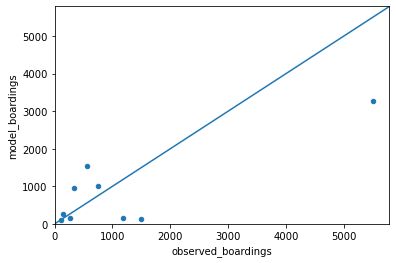

In [6]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

##### bikes on ferry

In [7]:
df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
df['route_code'] = df['route_code'].astype('int')
df[['route_code','description', '@bvol']]

,route_code,description,@bvol
4,4203,Annapolis Foot Ferry,794.30
2,4200,Bremerton-Seattle Fa,476.30
3,4201,Bremerton-Port Orcha,440.00
0,1973,E,352.30
1,1975,N,175.30
10,5005,Vashon Island - Faun,74.60
11,5007,Point Defiance - Tah,73.00
7,5002,Bainbridge Island -,55.10
9,5004,Fauntleroy - Southwo,37.30
8,5003,WSF Seattle - Bremer,11.00


In [8]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Link Red Line,"79,522.00","77,355.64","-2,166.36",-2.72%
1,Sounder South,"6,038.00","12,073.83","6,035.83",99.96%
2,Sounder North,316.00,13.40,-302.60,-95.76%


C:\ProgramData\Anaconda3\envs\joanne\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



r^2 : 0.9967525348316687


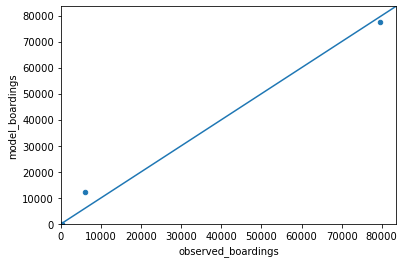

In [9]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [10]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
2,Sound Transit 550,"3,351.00","9,993.96","6,642.96",198.24%
1,First Hill Streetcar,"3,900.45","1,363.18","-2,537.27",-65.05%
0,SLU Streetcar,"1,050.16","1,080.83",30.67,2.92%


C:\ProgramData\Anaconda3\envs\joanne\lib\site-packages\pandas\plotting\_matplotlib\core.py:1041: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



r^2 : 0.3604727926130998


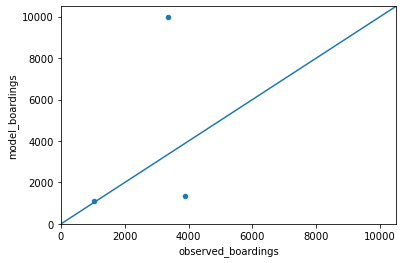

In [11]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### boarding on lines by agency

r^2 Everett Transit: 0.9499463362345166
r^2 King County Metro: 0.0936044294392241
r^2 Kitsap Transit: 0.5974905495201908


r^2 Sound Transit: 0.9877480106115335
r^2 Washington Ferries: 0.8582897271998384


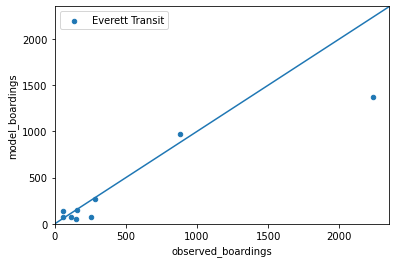

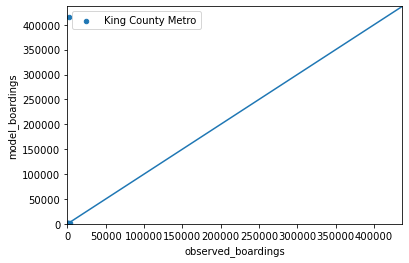

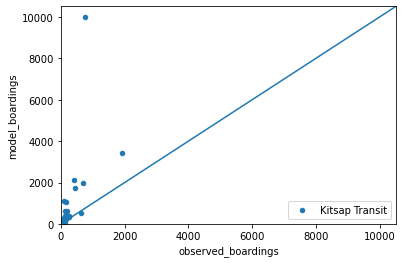

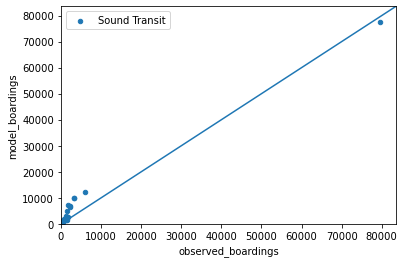

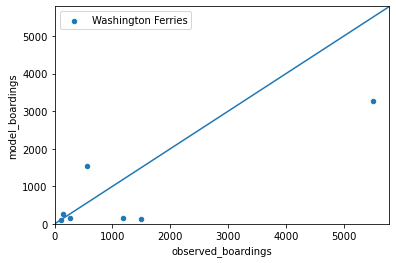

In [12]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [13]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Husky Stadium,"6,134.00","4,235.18","-1,898.82",-30.96%
Westlake,"8,845.00","9,299.29",454.29,5.14%
University St,"4,324.00","5,971.65","1,647.65",38.10%
Pioneer Square,"2,400.00","5,004.91","2,604.91",108.54%
Int'l District,"4,399.00","1,649.68","-2,749.32",-62.50%
Capitol Hill,"7,667.00","6,610.83","-1,056.17",-13.78%
Stadium,"1,731.00",552.58,"-1,178.42",-68.08%
SODO,"1,669.00","3,153.46","1,484.46",88.94%
Beacon Hill,"2,147.00",989.78,"-1,157.22",-53.90%


In [14]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/University St'
df_combined.loc[['University St'],'station_group'] = 'Westlake/University St'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined.loc[['Husky Stadium','Capitol Hill','Westlake/University St',"Pioneer Square/Int'l District",
                 'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                 "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

,observed_boardings,model_boardings,diff,percent_diff
station_group,,,,
Husky Stadium,"6,134.00","4,235.18","-1,898.82",-30.96%
Capitol Hill,"7,667.00","6,610.83","-1,056.17",-13.78%
Westlake/University St,"13,169.00","15,270.94","2,101.94",15.96%
Pioneer Square/Int'l District,"6,799.00","6,654.59",-144.41,-2.12%
Stadium/SODO,"3,400.00","3,706.04",306.04,9.00%
Beacon Hill/Mount Baker,"4,008.00","2,074.20","-1,933.80",-48.25%
Columbia City,"1,630.00","1,060.71",-569.29,-34.93%
Othello/Rainier Beach,"3,525.00","2,496.10","-1,028.90",-29.19%
Tukwila Int'l Blvd,"2,298.00","1,794.43",-503.57,-21.91%


### light rail stop transfers

In [15]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Husky Stadium,0.91,-99.00,99.91,-100.92%
Westlake,0.18,0.36,-0.19,-51.82%
University St,0.27,0.20,0.07,33.02%
Pioneer Square,0.44,0.16,0.28,174.44%
Int'l District,0.68,0.45,0.23,51.19%
Capitol Hill,0.07,-99.00,99.07,-100.07%
Stadium,0.27,0.12,0.15,128.30%
SODO,0.57,0.31,0.26,83.42%
Beacon Hill,0.37,0.35,0.01,3.92%
